In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
"""
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

#pip install xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn import preprocessing

import talib

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

In [ ]:
name=["2330"][0]
stock=pd.read_csv(f"{name}.txt", sep = ",", encoding = "utf-8", engine = "c")
stock.columns=['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']
stock["Datetime"]=stock["Date"]+" "+stock["Time"]
stock["Datetime"] = pd.to_datetime(stock["Datetime"])
stock=stock.set_index(stock["Datetime"]).drop(columns = ['Date','Time',"Datetime"])
#分K轉日Ｋ
stock_day=stock.resample("B").agg(dict(zip(stock.columns,["first", "max", "min", "last", "sum"]))).dropna()
print(stock_day.head())
#籌碼資料
chip=pd.read_csv(f"{name}籌碼.csv", encoding = "Big5")
chip["Datetime"] = pd.to_datetime(chip["年月日"], format='%Y%m%d')
chip=chip.set_index(chip["Datetime"]).drop(columns = ['證券代碼','簡稱',"年月日","Datetime"])
chip.head()

             open   high    low  close    volume
Datetime                                        
2016-06-02  159.0  160.0  158.0  159.0  21227000
2016-06-03  159.0  160.5  159.0  160.5  31208000
2016-06-06  161.0  162.0  160.0  161.0  28757000
2016-06-07  161.5  163.5  161.0  162.0  47046000
2016-06-08  164.0  166.0  163.5  165.5  45214000


,未調整收盤價(元),外資買賣超(張),投信買賣超(張),自營買賣超(張),融資增加(張),融資減少(張),融券增加(張),融券減少(張),外資買賣超日數,投信買賣超日數,...,自營持股率％,董監持股％,董監質押％,融資餘額(張),融資餘額(千元),融資使用率,融券餘額(張),融券餘額(千元),融券使用率,券資比
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-02,159.0,6857,-40,-447,0,432,181,0,7,-4,...,0.02,7.0,0.0,12654,2013251.40,0.20,3281,522007.10,0.05,25.93
2016-06-03,160.5,16979,-171,-289,0,587,531,0,8,-5,...,0.02,7.0,0.0,12067,1931202.68,0.19,3812,610072.48,0.06,31.59
2016-06-04,160.0,752,-708,646,0,26,0,73,9,-6,...,0.02,7.0,0.0,12041,1923790.57,0.19,3739,597380.03,0.06,31.05
2016-06-06,161.0,11302,-105,72,0,260,35,0,10,-7,...,0.02,7.0,0.0,11781,1896269.76,0.18,3774,607463.04,0.06,32.03
2016-06-07,162.0,17830,18,536,0,173,487,0,11,1,...,0.02,7.0,0.0,11608,1885139.20,0.18,4261,691986.40,0.07,36.71


In [ ]:
data=pd.concat([stock_day, chip], axis=1).dropna()
#價量指標
data["EMA"]= talib.EMA(data["close"], timeperiod = 5)
data["CCI"]  = talib.CCI(data['high'], data['low'],data["close"],timeperiod=10)
data["SAR"]=talib.SAREXT(data['high'], data['low'])
data["ADX"]= talib.ADX(data['high'], data['low'], data["close"], timeperiod=10)
data["OBV"] = talib.OBV(data["close"], data['volume'])
data["ATR"] = talib.ATR(data['high'], data['low'],data["close"], timeperiod=10)
data["AROONOSC"] = talib.AROONOSC(data['high'], data['low'], timeperiod=10)
data["RSI"] = talib.RSI(data["close"], timeperiod=10)
#資料處理
data.drop(['未調整收盤價(元)'],inplace=True, axis=1)
data=data[['open', 'high', 'low', 'close', 'volume',"EMA","CCI","SAR","ADX","OBV","ATR","AROONOSC","RSI", 
        '外資買賣超(張)', '投信買賣超(張)','自營買賣超(張)','外資買賣超日數','投信買賣超日數', 
        '自營買賣超日數', '外資連續累計買賣超(張)', '投信連續累計買賣超(張)', '自營連續累計買賣超(張)','外資成交比重', '投信成交比重', '自營成交比重', 
       '信用交易比重', '融資餘額(張)','融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)','融資增加(張)', '融資減少(張)','融券增加(張)', '融券減少(張)',
           '資券互抵(張)', '資券互抵比例', '實際週轉率％','融資使用率', '融券使用率', '券資比',
       '外資總持股率_不含董監%', '投信持股率％', '自營持股率％', '董監持股％', '董監質押％']]
data=data.replace('    -',0) 
data.astype(float)
"""
#資料正規化
minmax = preprocessing.MinMaxScaler()
minmaxlist=[] 
for i in range(len(minmaxlist)):
    data[minmaxlist[i]] = minmax.fit_transform(data[minmaxlist[i]].values.reshape(-1, 1))
  
#變成 pct_change    
pct_list=["EMA","CCI","SAR","ADX","OBV","ATR","AROONOSC","RSI"]
for i in range(len(pct_list)):
    data[pct_list[i]] = data[pct_list[i]].pct_change()
    
#短期去趨勢
zscorelist=[]

def zscore(x, window):
    r = x.rolling(window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

for i in range(len(zscorelist)):
    data[zscorelist[i]] = zscore(data[zscorelist[i]], window=5)
"""
#資料標準化
scaler = preprocessing.StandardScaler()
scalerlist=["EMA","CCI","SAR","ADX","OBV","ATR","AROONOSC","RSI",'外資買賣超(張)', '投信買賣超(張)','自營買賣超(張)', 
            '外資連續累計買賣超(張)', '投信連續累計買賣超(張)', '自營連續累計買賣超(張)',
           '外資成交比重', '投信成交比重', '自營成交比重',
            '信用交易比重','融資餘額(張)','融資餘額(千元)','融券餘額(張)', '融券餘額(千元)',
            '融資使用率', '融券使用率','資券互抵比例', '券資比', '資券互抵(張)', '實際週轉率％',
            '外資總持股率_不含董監%', '投信持股率％','自營持股率％','董監持股％', '董監質押％']
for i in range(len(scalerlist)):
    data[scalerlist[i]] = scaler.fit_transform(data[scalerlist[i]].values.reshape(-1, 1))
    
#不調整
# '外資買賣超日數','投信買賣超日數', '自營買賣超日數'

data

#data.isnull().any()
#data.isin([np.inf, -np.inf]).any()

,open,high,low,close,volume,EMA,CCI,SAR,ADX,OBV,...,資券互抵比例,實際週轉率％,融資使用率,融券使用率,券資比,外資總持股率_不含董監%,投信持股率％,自營持股率％,董監持股％,董監質押％
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-02,159.0,160.0,158.0,159.0,21227000.0,NaN,NaN,NaN,NaN,-0.458448,...,3.980728,-0.712251,-0.541658,0.754167,0.451124,0.453124,0.959513,0.117485,1.182246,-2.116918
2016-06-03,159.0,160.5,159.0,160.5,31208000.0,NaN,NaN,0.394854,NaN,-0.415820,...,1.781403,-0.232298,-0.612425,1.119802,0.740693,0.487310,0.909796,0.117485,1.182246,-2.116918
2016-06-06,161.0,162.0,160.0,161.0,28757000.0,NaN,NaN,0.394988,NaN,-0.376541,...,3.745086,-0.352287,-0.683191,1.119802,0.763203,0.504402,0.909796,0.117485,1.182246,-2.116918
2016-06-07,161.5,163.5,161.0,162.0,47046000.0,NaN,NaN,0.395410,NaN,-0.312280,...,0.917383,0.607619,-0.683191,1.485436,1.002634,0.544285,0.909796,0.117485,1.182246,-2.116918
2016-06-08,164.0,166.0,163.5,165.5,45214000.0,-1.124517,NaN,0.396259,NaN,-0.250522,...,2.174140,0.487631,-0.753957,1.485436,1.103932,0.589866,0.909796,0.117485,1.182246,-2.116918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-14,507.0,515.0,507.0,513.0,38668334.0,1.164910,-1.710583,-1.521871,-0.793671,-1.860657,...,-0.339373,0.127666,1.864396,-1.074004,-0.875467,-2.817272,2.550455,-0.666992,-0.848735,0.472385
2022-06-15,508.0,515.0,508.0,509.0,37543225.0,1.132216,-1.335918,-1.516300,-0.663077,-1.911938,...,-0.339373,0.127666,1.864396,-1.074004,-0.875467,-2.834365,2.550455,-0.666992,-0.848735,0.472385
2022-06-16,515.0,516.0,507.0,508.0,27708829.0,1.108316,-1.060967,-1.510953,-0.545543,-1.949786,...,-0.103732,-0.232298,1.793629,-1.074004,-0.860119,-2.822970,2.550455,-0.666992,-0.848735,0.472385


count    1469.00
mean        0.48
std         0.29
min         0.00
25%         0.25
50%         0.50
75%         0.70
max         1.00
Name: physical, dtype: float64
All     label=1 :  760 label=0 :  689
Train   label=1 :  501 label=0 :  513
Test    label=1 :  259 label=0 :  176


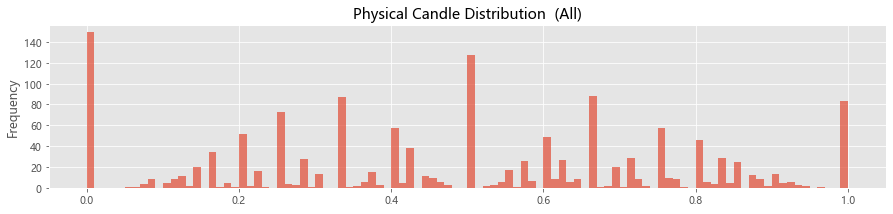

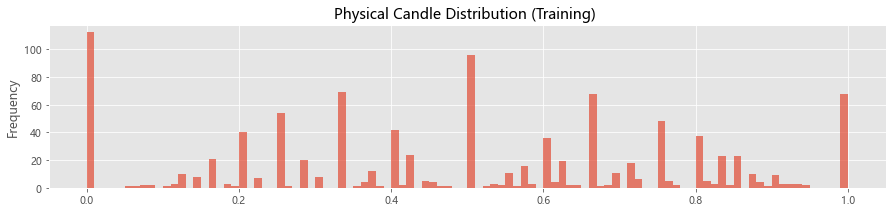

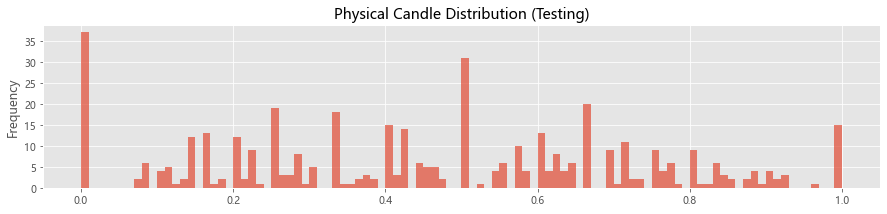

In [ ]:
#實體K占比
data["physical"]=abs(data.close-data.open)/(data.high-data.low)
print(data["physical"].describe().round(2))

# y_label=1:實體K占比>=50%百分位數時 & 實體K至少>1, else=0
N1=0.4
N2=1

data["Trend"]=np.where((data["physical"]>=N1)&(abs(data.close-data.open)>N2),1,0)

#Trend往上移動一天
data.Trend=data.Trend.shift(-1)
#昨日trend=1
data["yes_Trend"]=data.Trend.shift(1)
data=data.dropna()

# trend 放到最右邊
trend=data.Trend
data=data.drop(columns = ["Trend"])
data["Trend"]=trend

#66個月
#split data
start="2017-01-01"
trainend="2020-09-01"
train = data[:trainend]
test = data[trainend:][1:]

print("All   "," label=1 : ",len(data[data["Trend"]==1]),"label=0 : ",len(data[data["Trend"]==0]))
print("Train  ","label=1 : ",len(train[train["Trend"]==1]),"label=0 : ",len(train[train["Trend"]==0]))
print("Test   ","label=1 : ",len(test[test["Trend"]==1]),"label=0 : ",len(test[test["Trend"]==0]))

data["physical"].plot.hist(grid=True,alpha =0.7,bins=100,figsize = (15,3),title="Physical Candle Distribution  (All)")
plt.show()
train["physical"].plot.hist(grid=True,alpha =0.7,bins=100,figsize = (15,3),title="Physical Candle Distribution (Training) ")
plt.show()
test["physical"].plot.hist(grid=True,alpha =0.7,bins=100,figsize = (15,3),title="Physical Candle Distribution (Testing)")
plt.show()

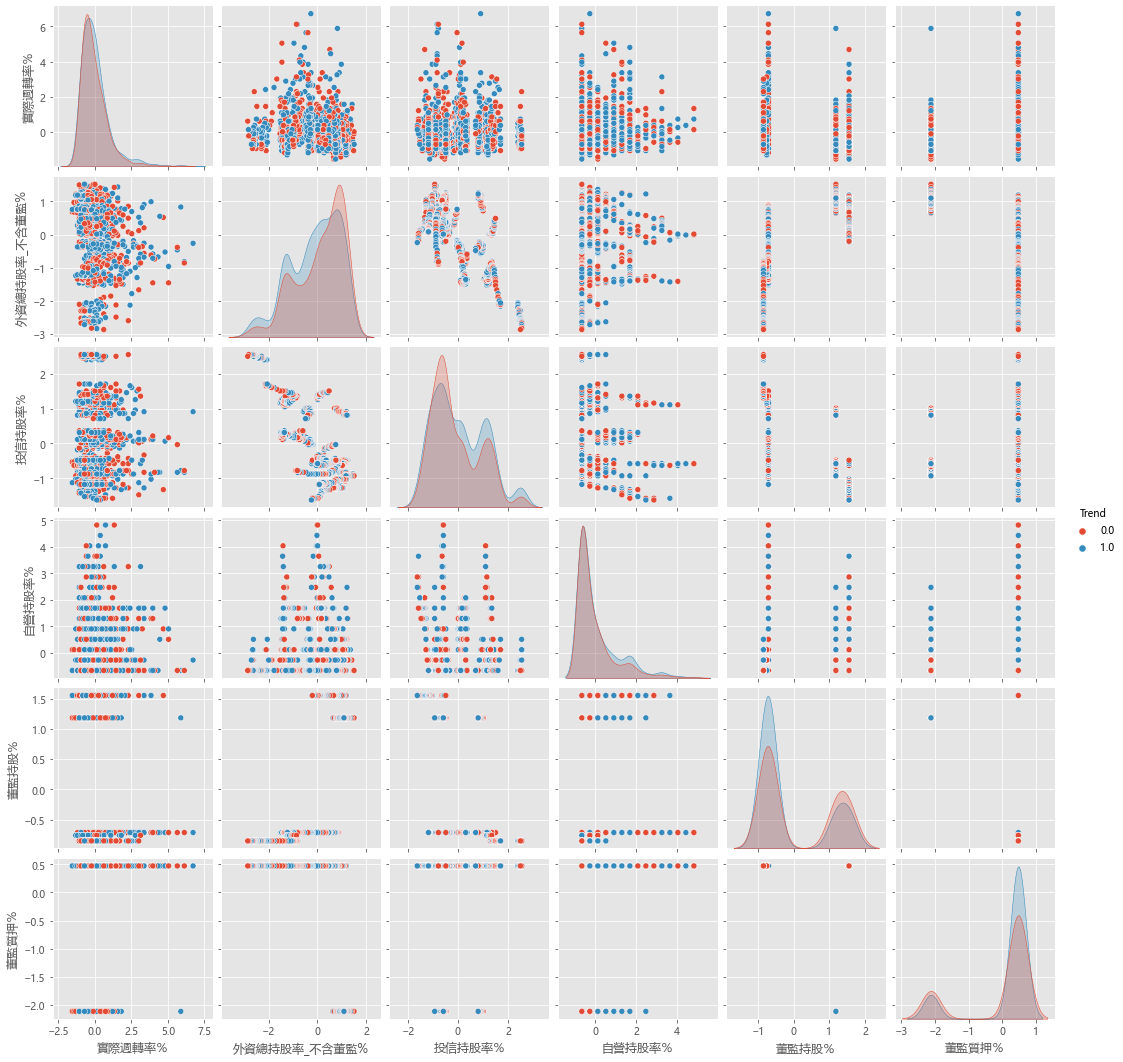

In [ ]:
# #price_volume
# price_volume=data.loc[:,["EMA","CCI","SAR","ADX","OBV","ATR","AROONOSC","RSI",
#                          "yes_Trend","physical","Trend"]]
# plt.style.use('ggplot')
# sns.pairplot(price_volume.dropna(),hue="Trend")
# plt.show()

# #institutions
# institutions=data.loc[:,['外資買賣超(張)', '投信買賣超(張)','自營買賣超(張)',
#                          '外資買賣超日數','投信買賣超日數', '自營買賣超日數', 
#                          '外資連續累計買賣超(張)', '投信連續累計買賣超(張)', '自營連續累計買賣超(張)',
#                          '外資成交比重', '投信成交比重', '自營成交比重',"Trend"]]
# plt.style.use('ggplot')
# sns.pairplot(institutions.dropna(),hue="Trend")
# plt.show()

# #credit
# credit=data.loc[:,['信用交易比重', '融資餘額(張)','融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', 
#            '資券互抵(張)', '資券互抵比例', '實際週轉率％','融資使用率', '融券使用率', '券資比',"Trend"]] #,'融資增加(張)', '融資減少(張)','融券增加(張)', '融券減少(張)'
# plt.style.use('ggplot')
# sns.pairplot(credit.dropna(),hue="Trend")
# plt.show()

#shares_list
shares_list=data.loc[:,['實際週轉率％','外資總持股率_不含董監%', '投信持股率％', '自營持股率％', '董監持股％', '董監質押％',"Trend"]]
plt.style.use('ggplot')
sns.pairplot(shares_list.dropna(),hue="Trend")
plt.show()

In [ ]:
#Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(data.iloc[:,5:-1].corr(), annot = False, center=0.0, cmap='coolwarm'); # cmap="YlGnBu",
plt.show()

Accuracy: 0.49  F1-score: 0.57  Precision: 0.57  Recall: 0.57


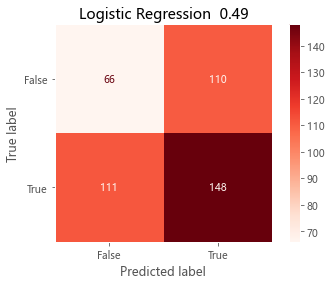

Accuracy: 0.59  F1-score: 0.71  Precision: 0.61  Recall: 0.84


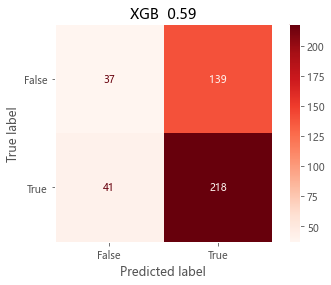

Accuracy: 0.52  F1-score: 0.62  Precision: 0.59  Recall: 0.65


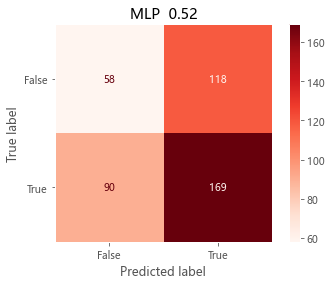

In [ ]:
#ML Methed
#籌碼only=> 
#train_x,train_y,test_x,test_y=train.iloc[:,13:-1].values,train['Trend'].values,test.iloc[:,13:-1].values,test['Trend'].values
#train_x,train_y,test_x,test_y=train.iloc[:,:-1].values,train['Trend'].values,test.iloc[:,:-1].values,test['Trend'].values

train_x,train_y,test_x,test_y=train.iloc[:,5:-1].values,train['Trend'].values,test.iloc[:,5:-1].values,test['Trend'].values #開高低收量不用

def model_outcome(model,title):
    
    model.fit(train_x, train_y)
    y_pred=model.predict(test_x)
    cm=confusion_matrix(test_y,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cmap=plt.cm.Reds
    cm_display.plot(cmap=cmap)

    accuracy=round(accuracy_score(test_y, y_pred),2)
    f1=round(f1_score(test_y, y_pred),2)
    precision=round(precision_score(test_y, y_pred),2)
    recall=round(recall_score(test_y, y_pred),2)
    
    print(f"Accuracy: {accuracy}",f" F1-score: {f1}",f" Precision: {precision}",f" Recall: {recall}")
    plt.title(title+f"  {accuracy}") 
    plt.grid(False)    

    return plt.show()
"""
#AdaBoost
model_outcome(model=AdaBoostClassifier(n_estimators=1000,learning_rate=0.2),title="AdaBoost")
#RandomForest
model_outcome(model=RandomForestClassifier(max_depth=5,n_estimators=200,random_state =50, min_samples_leaf = 12,min_samples_split=10,max_features="sqrt"),title="RandomForest")
#SVM
model_outcome(model=svm.SVC(),title="SVM")
#DecisionTree
model_outcome(model=DecisionTreeClassifier(criterion=["gini","entropy","log_loss"][0],splitter=["best", "random"][0],max_features=["auto","sqrt","log2"][2],max_depth=6,min_samples_leaf=5),title="Decision Tree") #75
"""

#LogisticRegression
model_outcome(model=LogisticRegression(max_iter=3000),title="Logistic Regression")
#XGB
model_outcome(model=XGBClassifier(learning_rate=0.0005, n_estimators=100, max_depth=3, min_child_weight=8),title="XGB")
#MLP
model_outcome(model=MLPClassifier(solver=["lbfgs", "sgd","adam"][2],  hidden_layer_sizes=(45,30,20,2), max_iter=2000,
                                  learning_rate_init=0.005,activation=["identity", "logistic","tanh", "relu"][2]),title="MLP")

Accuracy: 0.51  F1-score: 0.53  Precision: 0.61  Recall: 0.47


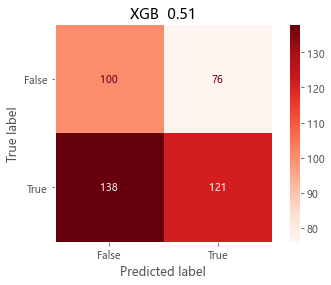

In [ ]:
model_outcome(model=XGBClassifier(learning_rate=0.0005, n_estimators=100, max_depth=6, min_child_weight=14),title="XGB")

In [ ]:
param_grid = {'learning_rate': np.arange(0.0005,0.005,0.0005),
             'n_estimators':np.arange(100,500,100),
             'max_depth':np.arange(3,12,3),
             'min_child_weight':np.arange(2,16,2)}

#model_outcome(model=XGBClassifier(learning_rate=0.0005, n_estimators=100, max_depth=3, min_child_weight=8),title="XGB")

grid_result = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid).fit(train_x,train_y)
print(f"最佳準確率: {round(grid_result.best_score_,2)}，最佳參數組合：{grid_result.best_params_}")

# 取得 cross validation 的平均準確率及標準差 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"平均準確率: {round(mean,2)}, 標準差: {round(stdev,2)}, 參數組合: {param}")

最佳準確率: 0.4，最佳參數組合：{'learning_rate': 0.0005, 'max_depth': 6, 'min_child_weight': 14, 'n_estimators': 100}
平均準確率: 0.38, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
平均準確率: 0.38, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
平均準確率: 0.38, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
平均準確率: 0.38, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
平均準確率: 0.39, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100}
平均準確率: 0.39, 標準差: 0.1, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 200}
平均準確率: 0.39, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 300}
平均準確率: 0.39, 標準差: 0.11, 參數組合: {'learning_rate': 0.0005, 'max_depth': 3, 'min_child_w

In [ ]:
# l_range= np.arange(0.1,0.5,0.1)
# k_scores = []
# for learning_rate in l_range:
#     model = XGBClassifier(learning_rate=learning_rate, n_estimators=200, max_depth=16, min_child_weight=2.5, gamma=0.3)
#     scores = cross_val_score(model,train_x,train_y,cv=5,scoring='accuracy')
#     k_scores.append(scores.mean())
    
# plt.plot(l_range,k_scores)
# plt.xlabel('K')
# plt.ylabel('Accuracy')
# plt.title("Cross-Validated")
# plt.show()

In [ ]:
# train_x,train_y,test_x,test_y=train.iloc[:,:-1].values,train['Trend'].values,test.iloc[:,:-1].values,test['Trend'].values

# np.save("train_x",train_x)
# np.save("train_y",train_y)
# np.save("test_x",test_x)
# np.save("test_y",test_y)